# Meteorological Data Extraction and Preprocessing

This notebook focuses on extracting meteorological data from the [ERA5 dataset](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview), encompassing temperature and precipitation records spanning from 2000 to 2024 on a daily basis. Our objective is to analyse the influence of weather patterns on food security, specifically by assessing key food security indicators: the Food Consumption Score (FCS) and Household Dietary Diversity Score (HDDS).

Utilizing the [ERA5 API](https://cds.climate.copernicus.eu/api-how-to) ,  we retrieve the meteorological data for our two study area, Tanzania and Rwanda in the NetCDF file format (.ncdf). Initial we compute the bounding box of each country to retrieve the weather data of the whole countries then we employ geospatial techniques to integrate the meteorological data with the administrative boundaries of country districts. By employing shapefiles containing the polygons representing each district's boundaries, we perform spatial operations such as clipping to precisely extract the corresponding temperature, precipitation, and other meteorological variables for each district from NetCDF data file. This approach enables us to obtain localized weather data, facilitating a district-level analysis of weather patterns and their impact on food security indicators. 

[ERA5 dataset](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview)

### Import Libraries

In [1]:
#!pip install cdsapi
#!pip install xarray cfgrib
#!pip install eccodes
#!pip install ecmwflibs
#!pip install scipy

In [2]:
import pandas as pd
from pandas import read_csv
import geopandas as gpd
from geopandas import read_file
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import requests
import calendar
import cdsapi
import ecmwflibs
import os

from scipy.io import netcdf
from netCDF4 import Dataset
import numpy as np
import cfgrib
import xarray as xr
import rioxarray as rx
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import time

## Helper Functions

This section contains a collection of utility functions designed to streamline and enhance various processes within the notebook. These functions serve as auxiliary tools that encapsulate specific tasks or computations, allowing for cleaner and more modular code organization.It include the functions for changing one file format of data to another, combine data files,batch processing function that allow the processing of many files on a single calls. This description of each function and what they provide is explained in document comments in each function.

In [3]:
def netcdf_to_dataframe(netcdf_file):
    
    '''
    Reads a netCDF file and converts its contents into a DataFrame.

    Parameters:
        netcdf_file (str): Path to the netCDF file.

    Returns:
        pandas.DataFrame: DataFrame containing the data from the netCDF file.
                          Each column represents a variable, and each row represents a time step.
    '''
    try:
        # Open the netCDF file using xarray
        ds = xr.open_dataset(netcdf_file,engine="netcdf4")

        # Convert the dataset to a pandas DataFrame
        df = ds.to_dataframe()

        return df

    except Exception as e:
        print("An error occurred:", str(e))
        return None


In [4]:
df = netcdf_to_dataframe('tanzania_data/meteo_data/tz_meteo_data.nc')

In [5]:
df.head(10)

t2m        tp         e
longitude latitude time                                      
29.327    -0.995   2010-01-01  295.880829  0.000809 -0.001740
                   2010-02-01  296.087982  0.004371 -0.001885
                   2010-03-01  295.218842  0.004558 -0.002872
                   2010-04-01  296.022400  0.003499 -0.002236
                   2010-05-01  295.849426  0.003046 -0.001784
                   2010-06-01  295.606293  0.002130 -0.001528
                   2010-07-01  295.844238  0.000186 -0.001236
                   2010-08-01  296.300629  0.000936 -0.001385
                   2010-09-01  295.551056  0.003568 -0.001815
                   2010-10-01  295.155701  0.004513 -0.002468

In [6]:
def checking_missing_value(df):
    
    '''
    This function takes a DataFrame as input and checks for missing values in each column.
    It prints a summary of the missing values, including the total count of missing values
    and the count per column. If no missing values are found, it prints a message indicating
    that no missing values were found.

    Parameters:
        df (DataFrame): The input DataFrame to be checked for missing values.

    Returns:
        DataFrame: The original DataFrame.
    '''
    
    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print("Missing values found in the dataset:")
        print(missing_values)
    else:
        print("No missing values found in the dataset.")

    return df


In [7]:
def compute_country_bounds(shapefile_path):
    '''
    Compute the bounds (minimum and maximum longitude and latitude) of a country in a shapefile.

    Parameters:
    - shapefile_path (str): Path to the shapefile.

    Returns:
    - country_bounds (DataFrame): DataFrame containing country,
      minimum longitude, maximum longitude, minimum latitude, and maximum latitude.
    
    '''
    
    # Read the shapefile
    gdf = read_file(shapefile_path)

    # Get the unique country name (assuming there is only one country in the shapefile)
    country_name = gdf['country'].unique()[0]

    # Compute the maximum and minimum longitude and latitude for the entire country
    country_bounds = pd.DataFrame({
        'country': [country_name],
        'min_lat': [gdf.total_bounds[1]],
        'min_lon': [gdf.total_bounds[0]],
        'max_lat': [gdf.total_bounds[3]],
        'max_lon': [gdf.total_bounds[2]]       
    })
    return country_bounds

In [8]:
def compute_district_bounds(shapefile_path):
    
    '''
    Compute the bounds (minimum and maximum longitude and latitude) of districts in a shapefile.

    Paramters:
        - shapefile_path (str): Path to the shapefile.

    Returns:
        - district_bounds (DataFrame): DataFrame containing region, district,
          minimum longitude, maximum longitude, minimum latitude, and maximum latitude.
    
    '''
    
    # Read the shapefile
    gdf = read_file(shapefile_path)

    # Group by district and compute the maximum and minimum longitude and latitude
    district_bounds = gdf.groupby(['region', 'district'])['geometry'].apply(lambda x: x.bounds).reset_index()

    # Extract maximum and minimum longitude and latitude values
    district_bounds['min_lon'] = district_bounds['minx']
    district_bounds['max_lon'] = district_bounds['maxx']
    district_bounds['min_lat'] = district_bounds['miny']
    district_bounds['max_lat'] = district_bounds['maxy']

    # Select relevant columns
    district_bounds = district_bounds[['region', 'district', 'min_lon', 'max_lon', 'min_lat', 'max_lat']]

    return district_bounds


In [9]:
def compute_statistics(df):
    """
    Compute statistics for weather data.

    Parameters:
        df (pandas.DataFrame): DataFrame containing weather data.

    Returns:
        pandas.DataFrame: DataFrame with computed statistics.
    """
    df['year'] = pd.to_datetime(df['time']).dt.year
    df['t2m_C'] = df['t2m'] - 273.15  # Convert temperature from Kelvin to Celsius
    df['e_mm'] = df['e'] * -1000  # Convert evaporation from meters to millimeters
    df['tp_mm'] = df['tp'] * 1000  # Convert total precipitation from meters to millimeters

    grouped = df.groupby(['year', 'province', 'district']).agg({
        't2m_C': ['min', 'max'],
        'e_mm': 'sum',
        'tp_mm': 'sum'
    }).reset_index()

    # Flatten MultiIndex columns
    grouped.columns = ['year', 'province', 'district', 't2m_min_C', 't2m_max_C', 'e_sum_mm', 'tp_sum_mm']

    return grouped

In [10]:
def compute_humidity_statistics(df):
    """
    Compute statistics for humidity data.

    Parameters:
        df (pandas.DataFrame): DataFrame containing humidity data.

    Returns:
        pandas.DataFrame: DataFrame with computed statistics.
    """
    df['year'] = pd.to_datetime(df['time']).dt.year

    grouped = df.groupby(['year', 'province', 'district']).agg({
        'r': ['min', 'max']
    }).reset_index()

    # Flatten MultiIndex columns
    grouped.columns = ['year', 'province', 'district', 're_hum_min', 're_hum_max']

    return grouped

In [11]:
def join_weather_and_humidity_data(weather_csv_path, humidity_csv_path, output_csv_path):
    """
    Joins weather data (evaporation, temperature, precipitation) with humidity data.

    Parameters:
        weather_csv_path (str): Path to the weather data CSV file.
        humidity_csv_path (str): Path to the humidity data CSV file.
        output_csv_path (str): Path to save the output joined CSV file.

    Returns:
        pandas.DataFrame: DataFrame containing the joined data.
    """
    # Load the weather data CSV file
    weather_df = pd.read_csv(weather_csv_path)

    # Load the humidity data CSV file
    humidity_df = pd.read_csv(humidity_csv_path)

    # Join the dataframes on year, region, and district
    joined_df = pd.merge(weather_df, humidity_df, on=['year', 'province', 'district'], how='outer')

    # Save the result DataFrame to a CSV file
    joined_df.to_csv(output_csv_path, index=False)
    print(f"Joined data has been saved to '{output_csv_path}'.")

    return joined_df


## Visualization Functions
In this section, a series of visualization functions are defined to plot different types of graphs and charts based on the data in the notebook. These functions play a crucial role in conveying insights and patterns hidden within the data in a visual and intuitive manner. It include the functions for visualizing the trends of the weather data such as temperature and precipitation and some other graphs.

In [12]:
def plot_nc_variable(nc_file, variable_name, time_index=0):
    '''
    Plot a variable from a NetCDF file.

    Parameters:
        nc_file (str): Path to the NetCDF file.
        variable_name (str): Name of the variable to plot.
        time_index (int): Index of the time dimension to plot (default is 0).
    '''
    # Open the .nc file
    nc_data = Dataset(nc_file, 'r')

    try:
        # Assuming you have latitude and longitude variables in the file
        lats = nc_data.variables['latitude'][:]
        lons = nc_data.variables['longitude'][:]
        data = nc_data.variables[variable_name][time_index, :, :]  # Extract variable data for a specific time

        # Plot the data
        plt.contourf(lons, lats, data)  # Contour plot
        plt.colorbar(label=f'{variable_name} (units)')  # Add colorbar
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title(f'{variable_name} Plot')
        plt.show()

    except KeyError:
        print(f"Variable '{variable_name}' not found in the NetCDF file.")

    # Close the file when done
    nc_data.close()


In [13]:
def plot_multiple_nc_variables(nc_file, variable_info, time_index=0):
    
    '''
    Plot multiple variables from a NetCDF file on a single row with different colors for contour plots.

    Parameters:
        nc_file (str): Path to the NetCDF file.
        variable_info (list): List of tuples, each containing the variable name and its display name.
        time_index (int): Index of the time dimension to plot (default is 0).
    '''
    # Open the .nc file
    nc_data = Dataset(nc_file, 'r')

    try:
        # Assuming you have latitude and longitude variables in the file
        lats = nc_data.variables['latitude'][:]
        lons = nc_data.variables['longitude'][:]

        # Create subplots
        num_vars = len(variable_info)
        fig, axs = plt.subplots(1, num_vars, figsize=(5*num_vars, 4))

        # Plot each variable
        colors = ['Reds', 'Blues', 'Greens']  # Different colors for contour plots
        for i, (var_name, display_name) in enumerate(variable_info):
            data = nc_data.variables[var_name][time_index, :, :]  # Extract variable data for a specific time
            cf = axs[i].contourf(lons, lats, data, cmap=colors[i])  # Contour plot with different colormap
            fig.colorbar(cf, ax=axs[i], label=f'{display_name} (units)')  # Add colorbar
            axs[i].set_xlabel('Longitude')
            axs[i].set_ylabel('Latitude')
            axs[i].set_title(f'{display_name} Plot')

        plt.tight_layout()
        plt.show()

    except KeyError:
        print("One or more variables not found in the NetCDF file.")

    # Close the file when done
    nc_data.close()


In [14]:
def plot_correlation_matrix(df, column_mapping, file_path=None, method='pearson'):
    # Extract the original column names and the display names
    original_columns = list(column_mapping.keys())
    display_names = list(column_mapping.values())
    
    # Calculate the correlation matrix
    correlation_matrix = df[original_columns].corr(method=method)
    
    # Set a fixed range for the color bar
    vmin, vmax = -1, 1
    
    # Plot the heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', fmt=".2f", linewidths=0.5,
                xticklabels=display_names, yticklabels=display_names, 
                cbar_kws={'label': 'Correlation Coefficient'}, annot_kws={"size": 8},
                vmin=vmin, vmax=vmax)
    plt.title('Correlation Between Meteorological Features', fontsize=10)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(fontsize=8)
    
    # Save or show the plot
    if file_path:
        plt.savefig(file_path)
        plt.show()
    else:
        plt.show()
    plt.close()  # Close the figure to prevent display in non-interactive environments

## ERA5 Dataset and Data Retrieval Methods
[ERA5](https://confluence.ecmwf.int/display/CKB/The+family+of+ERA5+datasets) dataset is a comprehensive reanalysis dataset produced by the European Centre for Medium-Range Weather Forecasts ([ECMWF](https://www.ecmwf.int)). ERA5 offers high-resolution atmospheric and land surface parameters spanning from 1940 to present, making it a valuable resource for climate research, weather forecasting, and environmental studies. There are various methods and tool utilized for access and retrieved data from ERA5 dataset as described [here](https://confluence.ecmwf.int/display/CKB/How+to+download+ERA5). In our case we use [CDS API](https://cds.climate.copernicus.eu/api-how-to) that allow us to access ERA5 data programmatically, through API it enables us to specify our data requirements such spatial and temporal extent, variables of our interest, output file format and retrieve the our desired data.

#### General Overview of ERA5 Dataset
* Data type : Gridded
* Projection : Regular latitude-longitude grid
* Horizontal coverage : Global
* Horizontal resolution : Reanalysis: 0.25° x 0.25° (atmosphere), 0.5° x 0.5° (ocean waves)
* Temporal coverage : 1940 to present
* Temporal resolution : Monthly or Hourly
* Update Frequency : Monthly if temporarly resolution is Monthly or daily if it Hourly
* File Format : GRIB or NetCDF

#### Main Variables Used 
There is a number of variables presents in ERA5 dataset, the more description about the those variables are available [here](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation).However in our task we use some of the variables that are suitable for our work, the following are the variables we use and some of description about them : 
* **2m_temperature** : represent the temperature of air at 2m above the surface of land, sea or inland waters. 2m temperature is calculated by interpolating between the lowest model level and the Earth's surface, taking account of the atmospheric conditions. This parameter has units of kelvin (K) which can be converted to degrees Celsius (°C) by subtracting 273.15. 
* **total_precipitation** : represent total precipitation accumulating liquid and frozen water, comprising rain and snow, that falls to the Earth's surface. This parameter has a unit of meter (m) which can be converted to millimeter(mm) by multiplying with 1000.

### Function to Fetch ERA5 Data Monthly
This function is used to fetch the ERA5 data by montly base, this description about how this data is computed is available [here](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview)

In [15]:
def fetch_ERA5_monthly_data(area, output_path, product_type='monthly_averaged_reanalysis', year_range=(1940, 2024), month_range=(1, 13), variable=['2m_temperature']):
    '''
    Fetches ERA5 data for a given region from the CDS API and saves it to a file.

    Parameters:
        area (list): A bounding box for the region with [min_lat,min_lon, max_lat, max_lon].
        output_path (str): Directory path where the downloaded file will be saved.
        product_type (str, optional): Type of product to retrieve. Defaults to 'monthly_averaged_reanalysis'.
        year_range (tuple, optional): Range of years to retrieve data for. Defaults to (1940, 2024).
        month_range (tuple, optional): Range of months to retrieve data for. Defaults to (1, 13).
        variable (list, optional): List of variables to retrieve. Defaults to ['2m_temperature'].

    Returns:
        str: Path to the saved file.
    '''
    try:
 
        # Initialize CDS API client
        c = cdsapi.Client()

        # Request parameters
        request = {
            'format': 'netcdf',
            'product_type': product_type,
            'variable': variable,
            'year': list(range(year_range[0], year_range[1])),
            'month': list(range(month_range[0], month_range[1])),
            'time': '00:00',
            'area': area,
        }

        # Send request to retrieve data
        response = c.retrieve('reanalysis-era5-single-levels-monthly-means', request)

        # Get the URL from the response
        download_url = response.location

        # Fetch data from the URL
        data_response = requests.get(download_url)

        # Check if request was successful
        data_response.raise_for_status()
        
        # Save the data to the output_path
        with open(output_path, "wb") as file:
            file.write(data_response.content)

        print(f"The Data have been successfully collected from CDS and saved in the file: {output_path}")
        #visualize_nc_file(output_path)
        return None

    except requests.exceptions.RequestException as e:
        print("Request failed:", e)
        return None
    except Exception as e:
        print("An error occurred:", e)
        return None

In [16]:
def fetch_ERA5_monthly_relative_humidity(area, output_path,year_range=(1940, 2024), month_range=(1, 13)):
    '''
    Fetches ERA5 data for a given region from the CDS API and saves it to a file.

    Parameters:
        area (list): A bounding box for the region with [min_lat,min_lon, max_lat, max_lon].
        output_path (str): Directory path where the downloaded file will be saved.
        product_type (str, optional): Type of product to retrieve. Defaults to 'monthly_averaged_reanalysis'.
        year_range (tuple, optional): Range of years to retrieve data for. Defaults to (1940, 2024).
        month_range (tuple, optional): Range of months to retrieve data for. Defaults to (1, 13).
        variable (list, optional): List of variables to retrieve. Defaults to ['2m_temperature'].

    Returns:
        str: Path to the saved file.
    '''
    try:
 
        # Initialize CDS API client
        c = cdsapi.Client()

        # Request parameters
        request = {
            'format': 'netcdf',
            'product_type': 'monthly_averaged_reanalysis',
            'pressure_level': '1',
            'variable': 'relative_humidity',
            'year': list(range(year_range[0], year_range[1])),
            'month': list(range(month_range[0], month_range[1])),
            'time': '00:00',
            'area': area,
        }

        # Send request to retrieve data
        response = c.retrieve('reanalysis-era5-pressure-levels-monthly-means', request)

        # Get the URL from the response
        download_url = response.location

        # Fetch data from the URL
        data_response = requests.get(download_url)

        # Check if request was successful
        data_response.raise_for_status()
        
        # Save the data to the output_path
        with open(output_path, "wb") as file:
            file.write(data_response.content)

        print(f"The Data have been successfully collected from CDS and saved in the file: {output_path}")
        #visualize_nc_file(output_path)
        return None

    except requests.exceptions.RequestException as e:
        print("Request failed:", e)
        return None
    except Exception as e:
        print("An error occurred:", e)
        return None

## District-Based Meteorological Data Extraction: Clipping ERA5 Data

In this section, we will focus on creating a function to extract data for each district within the country. As we explained early that the data will be collected from ERA5, encompassing the bounding box of the entire country. Our objective now is to refine this data by utilizing shapefiles containing the boundaries of each district within the country. The purpose of this function is to extract the relevant meteorological data specifically for a designated district, achieved through a process known as **Clipping**.Clipping involves using the polygon coordinates of each district to extract the corresponding meteorological data within its boundaries. By intersecting the district polygons with the ERA5 data grid, we can isolate the data points that fall within each district. This allows for a more granular analysis of meteorological parameters tailored to the specific geographical regions represented by each district. This function will automate this process, taking as input the ERA5 data and the shapefiles of district boundaries and output the extracted meteorological data for each district.
<p><img src="images/clipping_process.png"  align="centre" alt="The Clipping Process"></p>


In [17]:
def extract_weather_data(nc_file, shapefile, output_csv_path):
    """
    Extracts weather data from a NetCDF file for each geometry in a shapefile and computes statistics.

    Parameters:
        nc_file (str): Path to the NetCDF file.
        shapefile (str): Path to the shapefile.
        output_csv_path (str): Path to save the output CSV file.

    Returns:
        pandas.DataFrame: DataFrame containing extracted and computed weather data.
    """
    # Load the NetCDF file with xarray
    ds = xr.open_dataset(nc_file)
    ds.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)

    # Manually set the CRS if not defined
    if ds.rio.crs is None:
        ds.rio.write_crs("epsg:4326", inplace=True)

    # Load the shapefile with GeoPandas
    gdf = gpd.read_file(shapefile)

    # Convert GeoDataFrame CRS to match Dataset CRS
    if gdf.crs != ds.rio.crs:
        gdf = gdf.to_crs(ds.rio.crs)

    # Prepare a list to collect the results
    results = []

    # Determine the column name for administrative regions dynamically
    region_column_name = None
    for column_name in ['region', 'province']:  # Add other possible column names here
        if column_name in gdf.columns:
            region_column_name = column_name
            break

    # Loop through each geometry in the GeoDataFrame
    for idx, row in gdf.iterrows():
        geometry = row.geometry

        # Clip the dataset by the geometry
        clipped = ds.rio.clip([geometry], gdf.crs, drop=True, all_touched=True)

        # Process each clipped dataset
        if 'time' in clipped.dims:
            # Convert to DataFrame
            df = clipped.to_dataframe().reset_index()

            # Add region or province column
            if region_column_name:
                df[region_column_name] = row[region_column_name]
                df['district'] = row['district']  # assuming 'district' column always exists
                results.append(df)
            else:
                print("No administrative region column found in the shapefile. Skipping...")

        else:
            print(f"No data for geometry at index {idx} in the dataset.")

    # Combine all dataframes into a single DataFrame
    if results:
        combined_df = pd.concat(results, ignore_index=True)
        # Compute statistics
        result_df = compute_statistics(combined_df)
    else:
        result_df = pd.DataFrame()  # return an empty DataFrame if no results

    # Save the result DataFrame to a CSV file
    result_df.to_csv(output_csv_path, index=False)
    print(f"Data has been saved to '{output_csv_path}'.")

    return result_df


In [18]:
def extract_humidity_data(nc_file, shapefile, output_csv_path):
    """
    Extracts humidity data from a NetCDF file for each geometry in a shapefile and computes statistics.

    Parameters:
        nc_file (str): Path to the NetCDF file.
        shapefile (str): Path to the shapefile.
        output_csv_path (str): Path to save the output CSV file.

    Returns:
        pandas.DataFrame: DataFrame containing extracted and computed humidity data.
    """
    # Load the NetCDF file with xarray
    ds = xr.open_dataset(nc_file)
    ds.rio.set_spatial_dims(x_dim="longitude", y_dim="latitude", inplace=True)

    # Manually set the CRS if not defined
    if ds.rio.crs is None:
        ds.rio.write_crs("epsg:4326", inplace=True)

    # Load the shapefile with GeoPandas
    gdf = gpd.read_file(shapefile)

    # Convert GeoDataFrame CRS to match Dataset CRS
    if gdf.crs != ds.rio.crs:
        gdf = gdf.to_crs(ds.rio.crs)

    # Prepare a list to collect the results
    results = []

    # Determine the column name for administrative regions dynamically
    region_column_name = None
    for column_name in ['region', 'province']:  # Add other possible column names here
        if column_name in gdf.columns:
            region_column_name = column_name
            break

    # Loop through each geometry in the GeoDataFrame
    for idx, row in gdf.iterrows():
        geometry = row.geometry

        # Clip the dataset by the geometry
        clipped = ds.rio.clip([geometry], gdf.crs, drop=True, all_touched=True)

        # Process each clipped dataset
        if 'time' in clipped.dims:
            # Convert to DataFrame
            df = clipped.to_dataframe().reset_index()

            # Add region or province column
            if region_column_name:
                df[region_column_name] = row[region_column_name]
                df['district'] = row['district']  # assuming 'district' column always exists
                results.append(df)
            else:
                print("No administrative region column found in the shapefile. Skipping...")

        else:
            print(f"No data for geometry at index {idx} in the dataset.")

    # Combine all dataframes into a single DataFrame
    if results:
        combined_df = pd.concat(results, ignore_index=True)
        # Compute statistics
        result_df = compute_humidity_statistics(combined_df)
    else:
        result_df = pd.DataFrame()  # return an empty DataFrame if no results

    # Save the result DataFrame to a CSV file
    result_df.to_csv(output_csv_path, index=False)
    print(f"Data has been saved to '{output_csv_path}'.")

    return result_df


## Download and Extract Meteorological Data For Tanzania

In [19]:
#define a data directory
data_dir = 'tanzania_data/'

In [20]:
#Getting the bounding box of Tanzania
data = compute_country_bounds(data_dir+'shapefiles/tz_country.shp')
data.head()

,country,min_lat,min_lon,max_lat,max_lon
0,Tanzania,-11.745695,29.327168,-0.985788,40.445137


<Axes: >

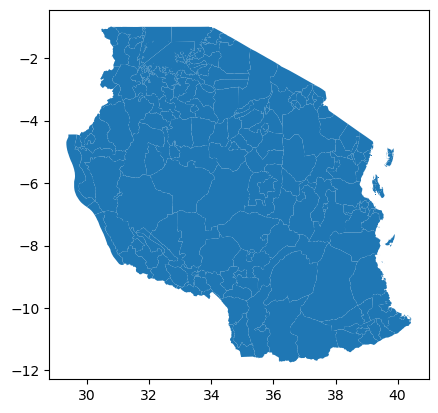

In [21]:
#load district shapefiles
shapefile = data_dir+'shapefiles/tz_districts.shp'
district = gpd.read_file(shapefile)
district.plot()

#### Download The Data

In [22]:
#area=[min_lat,min_lon, max_lat, max_lon]
area = [-11.745695, 29.327168, -0.985788, 40.445137] 
variables = ['2m_temperature','total_precipitation','evaporation']
output_path1 = data_dir+ 'meteo_data/tz_meteo_data.nc'
output_path2 = data_dir+ 'meteo_data/tz_meteo_data2.nc'
product_type='monthly_averaged_reanalysis'
month_range=(1,13)
year_range = (2010,2024)
#fetch_ERA5_monthly_data(area, output_path1, product_type,year_range, month_range, variables)
#fetch_ERA5_monthly_relative_humidity(area, output_path2,year_range, month_range=(1, 13))

### District Data Extraction

In [23]:
data_dir = 'tanzania_data/'
nc1 = data_dir+ 'meteo_data/tz_meteo_data.nc'
nc2 = data_dir+ 'meteo_data/tz_meteo_data2.nc' #contain only relative humidity data
shapefile = data_dir + 'shapefiles/tz_districts.shp'
output_path = data_dir+ 'meteo_data/processed/meteo.csv'
output_path2 = data_dir+ 'meteo_data/processed/meteo2.csv'
#extract_weather_data(nc1, shapefile, output_path)
#extract_humidity_data(nc2, shapefile,output_path2)

In [24]:
weather_csv_path = data_dir+ 'meteo_data/processed/meteo.csv'
humidity_csv_path = data_dir+ 'meteo_data/processed/meteo2.csv'
output_csv_path = data_dir+ 'meteo_data/processed/tz_weather_data.csv'
#join_weather_and_humidity_data(weather_csv_path, humidity_csv_path, output_csv_path)

In [25]:
df = read_csv(data_dir+ 'meteo_data/processed/tz_weather_data.csv',delimiter=',')
df.head()

,year,region,district,t2m_min_C,t2m_max_C,e_sum_mm,tp_sum_mm,re_hum_min,re_hum_max
0,2010,Arusha,Arusha,15.026398,25.054840,189.855900,238.96365,0.000146,0.000354
1,2010,Arusha,Arusha Urban,15.026398,24.014557,114.673615,134.25730,0.000146,0.000353
2,2010,Arusha,Karatu,14.710327,25.730255,464.427900,494.88780,0.000146,0.000354
3,2010,Arusha,Lake Eyasi,16.405579,25.730255,242.875730,179.44923,0.000147,0.000354
4,2010,Arusha,Lake Manyara,18.880920,24.629883,54.282250,36.20978,0.000147,0.000353


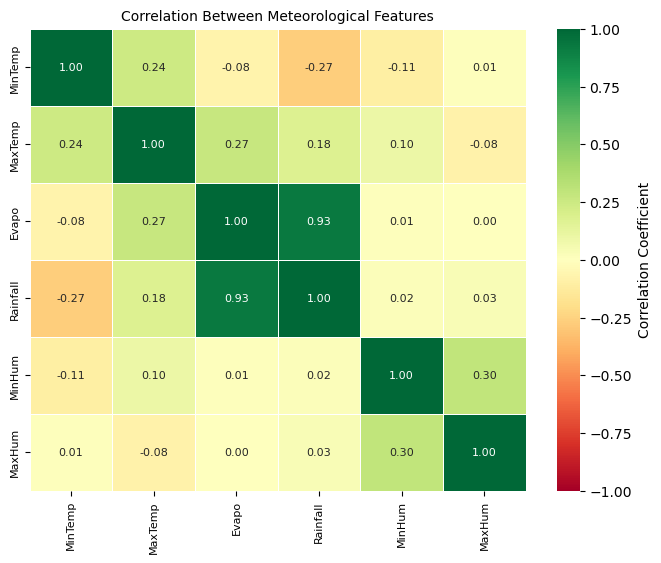

In [26]:
save_path= 'conjunctural_graph/tz_meteo_graph.png' 
numerical_features = {'t2m_min_C': 'MinTemp', 't2m_max_C': 'MaxTemp', 'e_sum_mm': 'Evapo',
                      'tp_sum_mm': 'Rainfall', 're_hum_min': 'MinHum', 're_hum_max': 'MaxHum'}
plot_correlation_matrix(df, numerical_features,save_path)

## Download and Extract Meteorological Data For Rwanda

In [27]:
#define a data directory
data_dir_rw = 'rwanda_data/'

In [28]:
#Getting the bounding box of Rwanda
data = compute_country_bounds(data_dir_rw+'shapefiles/rw_country.shp')
data.head()

,country,min_lat,min_lon,max_lat,max_lon
0,Rwanda,-2.839973,28.861708,-1.04745,30.899073


#### Download The Data

In [29]:
#area=[min_lat,min_lon, max_lat, max_lon]
area = [-2.839973, 28.861708, -1.04745, 30.899073] 
variables = ['2m_temperature','total_precipitation','evaporation']
output_path1 = data_dir_rw + 'meteo_data/rw_meteo_data.nc'
output_path2 = data_dir_rw + 'meteo_data/rw_meteo_data2.nc'
product_type='monthly_averaged_reanalysis'
month_range=(1,13)
year_range = (2006,2022)
#fetch_ERA5_monthly_data(area, output_path, product_type,year_range, month_range, variables)
#fetch_ERA5_monthly_relative_humidity(area, output_path2,year_range, month_range=(1, 13))

#### Extra The Data For Each District

<Axes: >

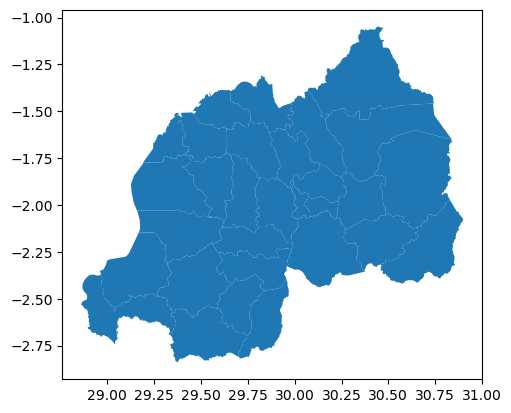

In [30]:
#load district shapefiles
rw_shapefile = data_dir_rw +'shapefiles/rw_district.shp'
rw_district = gpd.read_file(rw_shapefile)
rw_district.plot()

In [32]:
nc1 = data_dir_rw+ 'meteo_data/rw_meteo_data.nc'
nc2 = data_dir_rw+ 'meteo_data/rw_meteo_data2.nc' #contain only relative humidity data'
output_path = data_dir_rw+ 'meteo_data/processed/meteo.csv'
output_path2 = data_dir_rw+ 'meteo_data/processed/meteo2.csv'
#extract_weather_data(nc1, rw_shapefile, output_path)
#extract_humidity_data(nc2, rw_shapefile,output_path2)

In [33]:
weather_csv_path = data_dir_rw+ 'meteo_data/processed/meteo.csv'
humidity_csv_path = data_dir_rw+ 'meteo_data/processed/meteo2.csv'
output_csv_path = data_dir_rw+ 'meteo_data/processed/rw_weather_data.csv'
#join_weather_and_humidity_data(weather_csv_path, humidity_csv_path, output_csv_path)

In [34]:
df = read_csv(data_dir_rw+ 'meteo_data/processed/rw_weather_data.csv',delimiter=',')
df.head()

,year,province,district,t2m_min_C,t2m_max_C,e_sum_mm,tp_sum_mm,re_hum_min,re_hum_max
0,2006,Amajyaruguru,Burera,15.352936,19.953583,206.43960,434.53677,0.000162,0.000377
1,2006,Amajyaruguru,Gakenke,15.352936,19.232300,125.76372,320.24246,0.000162,0.000377
2,2006,Amajyaruguru,Gicumbi,16.456635,21.920105,219.61433,352.25967,0.000162,0.000377
3,2006,Amajyaruguru,Musanze,15.352936,18.537750,183.05183,504.36700,0.000162,0.000377
4,2006,Amajyaruguru,Rulindo,16.711975,20.492584,122.95829,206.85823,0.000162,0.000377


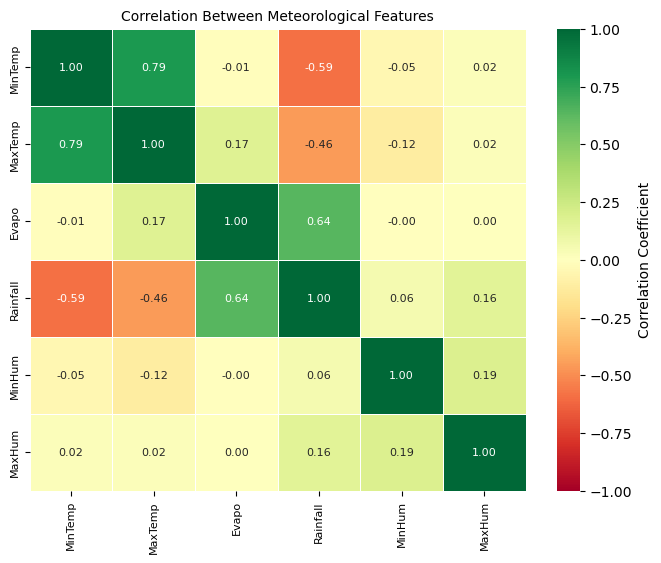

In [35]:
save_path= 'conjunctural_graph/rw_meteo_graph.png' 
numerical_features = {'t2m_min_C': 'MinTemp', 't2m_max_C': 'MaxTemp', 'e_sum_mm': 'Evapo',
                      'tp_sum_mm': 'Rainfall', 're_hum_min': 'MinHum', 're_hum_max': 'MaxHum'}
plot_correlation_matrix(df, numerical_features,save_path)